In [42]:
import csv
import re
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy as sp
from scipy.optimize import curve_fit
from scipy.optimize import brentq
import random as r

In [52]:
data = pd.read_csv("HYG_data/hygdata_v3.csv")
#from wikipedia
starclass = pd.read_csv("StarClass.csv")
#from http://www.isthe.com/chongo/tech/astro/HR-temp-mass-table-byhrclass.html
starclass_extended = pd.read_csv("StellarClass_Extended.csv")
data_extended_fullmatch = pd.read_csv("HYG_data/hygdata_v3_exactmatch_class.csv")
data_ef = data_extended_fullmatch
data_ef["vtot"] = (data_ef["vx"]**2+data_ef["vy"]**2+data_ef["vz"]**2)**(0.5)
data_ef

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,mass,luminosity,radius,temperature,color_index,abs_mag,bolometric_correction,bolometric_magnitude,rgb,vtot
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,1.0,1.230000,1.14000,5780,0.69,4.7,-0.18,4.52,255 245 242,0.000000
1,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,0.7,0.335000,0.99000,4480,1.10,6.7,-0.76,5.94,255 222 195,0.000042
2,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,1.6,7.940000,1.77000,7400,0.30,2.6,-0.10,2.50,224 229 255,0.000041
3,5,5.0,224705.0,NaN,NaN,NaN,NaN,0.000665,-40.591202,257.7320,...,2.2,124.000000,21.40000,4229,1.19,0.5,-0.98,-0.48,255 231 199,0.000012
4,10,10.0,224717.0,NaN,NaN,NaN,NaN,0.002424,-50.866976,92.3361,...,1.3,3.130000,1.41000,6560,0.49,3.6,-0.09,3.51,244 241 255,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39726,119533,NaN,NaN,NaN,GJ 1275,NaN,NaN,22.856204,29.662170,20.7039,...,0.1,0.000067,0.00898,5600,0.74,15.4,-0.22,15.18,255 239 225,0.000126
39727,119552,NaN,NaN,NaN,Gl 893.1,NaN,NaN,23.240333,-6.548251,24.4499,...,0.4,0.000315,0.00864,8400,0.09,13.7,-0.20,13.50,224 230 255,0.000044
39728,119589,NaN,NaN,NaN,Gl 905.2B,NaN,NaN,23.730688,32.546681,16.6362,...,0.6,0.001820,0.00922,12600,-0.13,12.5,-0.90,11.60,192 207 255,0.000025
39729,119596,NaN,NaN,NaN,NN 4365,NaN,NaN,23.831738,29.567389,21.2766,...,0.1,0.000067,0.00898,5600,0.74,15.4,-0.22,15.18,255 239 225,0.000055


In [76]:
#use a list to take multiple columns:
#data_ef[["absmag","abs_mag"]]

data_ef.columns

Index(['id', 'hip', 'hd', 'hr', 'gl', 'bf', 'proper', 'ra', 'dec', 'dist',
       'pmra', 'pmdec', 'rv', 'mag', 'absmag', 'spect', 'ci', 'x', 'y', 'z',
       'vx', 'vy', 'vz', 'rarad', 'decrad', 'pmrarad', 'pmdecrad', 'bayer',
       'flam', 'con', 'comp', 'comp_primary', 'base', 'lum', 'var', 'var_min',
       'var_max', 'inserted_at', 'updated_at', 'id-2', 'stellar_type', 'mass',
       'luminosity', 'radius', 'temperature', 'color_index', 'abs_mag',
       'bolometric_correction', 'bolometric_magnitude', 'rgb', 'vtot'],
      dtype='object')

In [44]:
starclass

,Class,Effective temperature (K),Vega-relative chromaticity,Chromaticity (D65),Main-sequence mass (solar masses),Main-sequence radius (solar radii),Main-sequence luminosity (bolometric),Hydrogen lines,Fraction of all main-sequence stars
0,O,">=30,000",blue,blue,>=16,>=6.6,">=30,000",Weak,0.00003
1,B,"10,000-30,000",blue white,deep blue white,2.1-16,1.8-6.6,"25-30,000",Medium,0.00130
2,A,"7,500-10,000",white,blue white,1.4-2.1,1.4-1.8,5-25,Strong,0.00600
3,F,"6,000-7,500",yellow white,white,1.04-1.4,1.15-1.4,1.5-5,Medium,0.03000
4,G,"5,200-6,000",yellow,yellowish white,0.8-1.04,0.96-1.15,0.6-1.5,Weak,0.07600
5,K,"3,700-5,200",light orange,pale yellow orange,0.45-0.8,0.7-0.96,0.08-0.6,Very weak,0.12100
6,M,"2,400-3,700",orange red,light orange red,0.08-0.45,<=0.7,<=0.08,Very weak,0.76450


In [45]:
starclass_extended
starclass_extended["Stellar Type"].astype("string")
avg = lambda nums : sum(nums)/len(nums)
#get the full details for some classification/part of a classification
starclass_extended[starclass_extended["Stellar Type"].str.contains("A5II")]


,Stellar Type,Mass (Mstar/Msun),Luminosity (Lstar/Lsun),Radius (Rstar/Rsun),Temp (K),Color Index (B-V),Abs Mag (Mv),Bolo Corr (BC(Temp)),Bolo Mag (Mbol),Star Color (RGB 0-255)
203,A5II,7.2,1290.0,16.50,8650,0.05,-2.8,-0.23,-3.03,194 210 255
204,A5III,5.4,56.4,3.45,8650,0.05,0.6,-0.23,0.37,202 215 255


In [46]:
starclass_extended["Stellar Type"]

0       O0Ia0
1        O0Ia
2        O0Ib
3        O0II
4       O0III
        ...  
1095      DZ5
1096      DZ6
1097      DZ7
1098      DZ8
1099      DZ9
Name: Stellar Type, Length: 1100, dtype: object

In [47]:
#M8 seems to have a fairly consistant temperature. We can call all M8* stars the average of the values
M8 = avg(starclass_extended[starclass_extended["Stellar Type"].str.contains("M8")]["Temp (K)"])

In [22]:
#query the data for specific things like this:
data[data.spect == "M8"]

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,flam,con,comp,comp_primary,base,lum,var,var_min,var_max,vtot
2590,2590,2596.0,NaN,NaN,NaN,NaN,NaN,0.549700,48.658277,344.8276,...,NaN,Cas,1,2590,NaN,2.265687e+00,V748,11.788,11.398,0.000013
3123,3123,3129.0,NaN,NaN,NaN,NaN,NaN,0.662778,14.200336,609.7561,...,NaN,Psc,1,3123,NaN,6.829674e+01,TW,9.500,9.060,0.000030
8665,8665,8682.0,NaN,NaN,NaN,NaN,NaN,1.862004,39.140635,523.5602,...,NaN,And,1,8665,NaN,1.300170e+01,V368,10.898,10.328,0.000027
9215,9215,9234.0,11979.0,NaN,NaN,NaN,NaN,1.978977,45.435250,174.2160,...,NaN,And,1,9215,NaN,2.409905e+01,V370,7.931,6.921,0.000033
14834,14834,14870.0,18472.0,NaN,NaN,NaN,NaN,3.199543,83.579405,564.9718,...,NaN,Cep,1,14834,NaN,5.248075e+01,OU,9.608,8.908,0.000023
17337,17337,17379.0,NaN,NaN,NaN,NaN,NaN,3.721695,12.793943,555.5556,...,NaN,Tau,1,17337,NaN,6.103796e+01,V1127,9.469,8.959,0.000036
40273,40273,40388.0,68775.0,NaN,NaN,NaN,NaN,8.245427,24.734816,285.7143,...,NaN,Cnc,1,40273,NaN,2.679168e+01,RX,9.012,8.222,0.000015
41186,41186,41302.0,NaN,NaN,NaN,NaN,NaN,8.427055,52.282221,578.0347,...,NaN,Lyn,1,41186,NaN,6.367955e+01,NaN,9.228,9.048,0.000061
44538,44538,44666.0,NaN,NaN,NaN,NaN,NaN,9.102424,64.779507,100000.0000,...,NaN,UMa,1,44538,NaN,4.405549e+05,FY,11.144,10.384,0.012836
44547,44547,44675.0,NaN,NaN,NaN,NaN,NaN,9.104654,-0.997450,100000.0000,...,NaN,Hya,1,44547,NaN,3.564511e+05,NaN,11.067,10.887,0.007849


In [30]:
set(data["spect"])

{nan,
 'F8/G0III',
 'B3Ia',
 'B8IIIe',
 'A5II/IIIm..',
 'M4e-M9e',
 'A2/A3III/IV',
 'G1/G2IV',
 'O9III:',
 'A5Vm...',
 'B2II:',
 'K1/2III: +F',
 'F7.5IV-V',
 'G1/G2II',
 'F2/F3II/III',
 'A0:Ib:',
 'A5III',
 'B7/B8III',
 'F3IVp...',
 'G8/K0Ib/II',
 'B9II',
 'M6  :',
 'B1.5Vne',
 'M1IIIb Ca-1',
 'C8',
 'N5',
 'F5IIIvar',
 'G5III',
 'B0Vn',
 'B1.5Ia:',
 'M2/M3III:',
 'B2Vp',
 'K1/K2III+F/G',
 'A5IIevar',
 'K5v...',
 'F6V',
 'M3e-M7e',
 'K5Ibv SB',
 'B1/B2Ib',
 'F2+...',
 'F3/F5IV+...',
 'K5IIIvar',
 'G8IV/Vw...',
 'F9V: + G9V:',
 'M2e-M8e',
 'A8/F0 + G/K',
 'K0III/IV',
 'B3V...',
 'G0:',
 'G1IV...',
 'M3S',
 'A2sh',
 'O8/O9Ib:',
 'B2.5Vn',
 'K0III-IVw..',
 'K0II-III',
 'A7Vm...',
 'A5m',
 'G1.2',
 'F3/F5Vw',
 'G4IV',
 'A4/A5III:',
 'B3III',
 'M7III',
 'B2IIIne+...',
 'M3III-IVvar',
 'K0Vea + DA',
 'F5I',
 'B3:nnpsh',
 'A5/7V(m)',
 'B8Ib',
 'M2.5III',
 'DA5',
 'K1/K2II/III',
 'K5II/III',
 'K4Ib',
 'B8Vev comp',
 'F0/F2IVw...',
 'G7IVw...',
 'M3/M4II:',
 'M6S',
 'G3/G5IV/V',
 'B0IVpe',
 'R0

In [25]:
data[data["vtot"]==max(data["vtot"])]

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,flam,con,comp,comp_primary,base,lum,var,var_min,var_max,vtot
13682,13682,13716.0,NaN,NaN,Gl 119B,NaN,NaN,2.943027,55.441584,100000.0,...,NaN,Per,2,13680,Gl 119,3.499452e+05,NaN,11.565,10.605,0.177141
71276,71276,71502.0,128267.0,NaN,NaN,NaN,NaN,14.622494,-46.127654,100000.0,...,NaN,Lup,1,71276,NaN,3.467369e+06,NaN,9.514,8.314,0.177141


In [44]:
ra = list(data["ra"])
id1=list(data["id"]) #the database primary key
hip=list(data["hip"]) #The star's ID in the Hipparcos catalog, if known
hd=list(data["hd"]) #The star's ID in the Henry Draper catalog, if known
hr=list(data["hr"]) #The star's ID in the Harvard Revised catalog
gl=list(data["gl"]) #The star's ID in the third edition of the Gliese Catalog of Nearby Stars
bf=list(data["bf"]) #The Bayer / Flamsteed designation
proper=list(data["proper"]) #common name for the star
ra=list(data["ra"]) #right ascension
dec=list(data["dec"]) #declination
dist=list(data["dist"]) #star's distance in parsecs
pmra=list(data["pmra"]) #star's proper motion in right ascension, in milliarcseconds per year
pmdec=list(data["pmdec"]) #star's proper motion in declination, in milliarcseconds per year
rv=list(data["rv"]) #The star's radial velocity in km/sec, where known
mag=list(data["mag"]) #The star's apparent visual magnitude
absmag=list(data["absmag"]) #star's absolute visual magnitude
spect=list(data["spect"]) #spectral type, if known
ci=list(data["ci"]) # star's color index (blue magnitude - visual magnitude), where known
x=list(data["x"]) # The Cartesian coordinates of the star
y=list(data["y"]) #
z=list(data["z"]) #
vx=list(data["vx"]) #The Cartesian velocity components of the star, parsecs per year
vy=list(data["vy"]) #
vz=list(data["vz"]) #
rarad=list(data["rarad"]) #right ascension in radians 
decrad=list(data["decrad"]) #declination in radians 
pmrarad=list(data["pmrarad"]) #proper motion right ascension, in radians 
pmdecrad=list(data["pmdecrad"]) #proper motion declination, in radians 
bayer=list(data["bayer"]) #The Bayer designation as a distinct value
flam=list(data["flam"]) #The Flamsteed number as a distinct value
con=list(data["con"]) #The standard constellation abbreviation
comp=list(data["comp"]) #Identifies a star in a multiple star system. comp = ID of companion star
comp_primary=list(data["comp_primary"]) #ID of primary star for this component
base=list(data["base"]) #catalog ID or name for this multi-star system
lum=list(data["lum"]) #Star's luminosity as a multiple of Solar luminosity
var=list(data["var"]) #Star's standard variable star designation, when known
var_min=list(data["var_min"]) #Star's approximate magnitude range, for variables
var_max=list(data["var_max"]) #


In [10]:
#create lists for these columns in the csv file
id1=[] #the database primary key
hip=[] #The star's ID in the Hipparcos catalog, if known
hd=[] #The star's ID in the Henry Draper catalog, if known
hr=[] #The star's ID in the Harvard Revised catalog
gl=[] #The star's ID in the third edition of the Gliese Catalog of Nearby Stars
bf=[] #The Bayer / Flamsteed designation
proper=[] #common name for the star
ra=[] #right ascension
dec=[] #declination
dist=[] #star's distance in parsecs
pmra=[] #star's proper motion in right ascension, in milliarcseconds per year
pmdec=[] #star's proper motion in declination, in milliarcseconds per year
rv=[] #The star's radial velocity in km/sec, where known
mag=[] #The star's apparent visual magnitude
absmag=[] #star's absolute visual magnitude
spect=[] #spectral type, if known
ci=[] # star's color index (blue magnitude - visual magnitude), where known
x=[] # The Cartesian coordinates of the star
y=[] #
z=[] #
vx=[] #The Cartesian velocity components of the star, parsecs per year
vy=[] #
vz=[] #
rarad=[] #right ascension in radians 
decrad=[] #declination in radians 
pmrarad=[] #proper motion right ascension, in radians 
pmdecrad=[] #proper motion declination, in radians 
bayer=[] #The Bayer designation as a distinct value
flam=[] #The Flamsteed number as a distinct value
con=[] #The standard constellation abbreviation
comp=[] #Identifies a star in a multiple star system. comp = ID of companion star
comp_primary=[] #ID of primary star for this component
base=[] #catalog ID or name for this multi-star system
lum=[] #Star's luminosity as a multiple of Solar luminosity
var=[] #Star's standard variable star designation, when known
var_min=[] #Star's approximate magnitude range, for variables
var_max=[] #


fields = [] #list of names of each column 

with open('HYG_data/hygdata_v3.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    fields = next(readCSV)
    for row in readCSV:
        id1.append(row[0])
        hip.append(row[1])
        hd.append(row[2])
        hr.append(row[3])
        gl.append(row[4])
        bf.append(row[5])
        proper.append(row[6])
        ra.append(row[7])
        dec.append(row[8])
        dist.append(row[9])
        pmra.append(row[10])
        pmdec.append(row[11])
        rv.append(row[12])
        mag.append(row[13])
        absmag.append(row[14])
        spect.append(row[15])
        ci.append(row[16])
        x.append(row[17])
        y.append(row[18])
        z.append(row[19])
        vx.append(row[20])
        vy.append(row[21])
        vz.append(row[22])
        rarad.append(row[23])
        decrad.append(row[24])
        pmrarad.append(row[25])
        pmdecrad.append(row[26])
        bayer.append(row[27])
        flam.append(row[28])
        con.append(row[29])
        comp.append(row[30])
        comp_primary.append(row[31])
        base.append(row[32])
        lum.append(row[33])
        var.append(row[34])
        var_min.append(row[35])
        var_max.append(row[36])

        

In [4]:
def convert(s):
    try:
        float(s) #check that each data point can be converted to float
        return float(s)
    except ValueError:
        return None 

stat ideas:


split stars into groups, different areas of the sky

compare star parameters in different areas of sky, look for statistically different sets



if ra <= __ and ra > __ and dec < ___ and dec __ > then:

group1.append(star)

else

group2.append(star)


look for correlations between:

1 total velocities 

2 absolute magnitude 

3 distance from earth

4 spectral type



generate HR diagrams

for each spectral type, get avg absolute mag w standard deviation, plot


to do:

convert spectral types to temp

get lists of floats for numerical analysis

In [57]:
uniques = set(spect)
print(uniques)

{nan, 'M4.5Ve', 'A6:III:+...', 'B5 + F2', 'G0Vw', 'G2Ib', 'B1Ia:', 'O6pe', 'B9.5III', 'B4/B5IV', 'M6IIIe-M8e', 'F7IIIw...', 'B9.5/A0III', 'F2+...', 'G6:III/IV+.', 'B7Ve...', 'B9IIIe...', 'K0/K1III:', 'M0V...', 'K3Ia0-a...', 'G5Ve(T)', 'B0.5:V:pe', 'Rpvar', 'F6/F7III/IV', 'F8Ibvar', 'O8', 'K1:III:', 'K0V...', 'G8IV:', 'C(R)', 'F3IV-V', 'G7', 'K5:...', 'F3/F5IV:', 'A8/A9IVw...', 'K0/K1IV/V', 'B8V', 'A:...', 'B0.5Iavar', 'G2wF6', 'A2 + A7', 'N', 'B3V SB', 'K5Iabvar', 'G1/G2IV/V', 'A7IVe', 'G8p...', 'A7/A8II/III', 'B4III', 'A6/A7IV/V', 'K0/K1IV', 'B9.5II/III', 'M2.5III:', 'dM1   J', 'sdF5', 'M5Ib-IIvar', 'B9p SiSrCr', 'F2/F3II', 'F2IV', 'A4/A5III/IV', 'sdG4', 'M1e', 'G6IV:', 'B0V:pe', 'F3Ib', 'B9.5IV/V +K2', 'M0/M1III:', 'B3/5V(p)', 'A0IIIn', 'M3Ia0', 'F6:+...', 'G8 V', 'A4/A7:m...', 'Ge', 'K0/K1+...', 'A7/A8V+...', 'K3.5IIb', 'A9', 'B8/B9IV/V', 'K8', 'A4/A5II/III', 'G8/K1(V)+(F)', 'K1IIpevar', 'F5:Ib-II', 'K4V:', 'F4IIIvar', 'B1.5V', 'F8/G0V', 'G2IV + K0IV', 'M4/M5', 'sdF7::', 'F8Ib/II', 

In [13]:
#use the set(someList) function to find all unique values in a list.
def unique(list1):
  
    # initialize a null list
    unique_list = []
  
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [14]:
allspects = []
spectypes = unique(spect)
spectypes.sort()
print(len(spectypes))
print(len(spect))
#print(spectypes)

4308
119614


In [8]:
temps = []
unknowns = 0
unknowntypes = []
for x in spect:
    if x == '':
        temps.append(0)
    elif x == 'O3V' or x == 'O3':
        temps.append(44900)
    elif x == 'O4V' or x == 'O4':
        temps.append(42900)
    elif x == 'O5V' or x == 'O5':
        temps.append(41400)
    elif x == 'O6V' or x == 'O6':
        temps.append(39500)
    elif x == 'O7V' or x == 'O7':
        temps.append(37100)
    elif x == 'O8V' or x == 'O8':
        temps.append(35100)
    elif x == 'O9V' or x == 'O9':
        temps.append(33300)
    elif x == 'A0V' or x == 'A0':
        temps.append(9700)
    elif x == 'A1V' or x == 'A1':
        temps.append(9300)
    elif x == 'A2V' or x == 'A2':
        temps.append(8800)
    elif x == 'A3V' or x == 'A3':
        temps.append(8600)
    elif x == 'A4V' or x == 'A4':
        temps.append(8250)
    elif x == 'A5V' or x == 'A5':
        temps.append(8100)
    elif x == 'A6V' or x == 'A6':
        temps.append(7910)
    elif x == 'A7V' or x == 'A7':
        temps.append(7760)
    elif x == 'A8V' or x == 'A8':
        temps.append(7590)
    elif x == 'A9V' or x == 'A9':
        temps.append(7400)
    elif x == 'B0V' or x == 'B0':
        temps.append(31400)
    elif x == 'B1V' or x == 'B1':
        temps.append(26000)
    elif x == 'B1.5V' or x == 'B1.5':    
        temps.append(24500)
    elif x == 'B2V' or x == 'B2':
        temps.append(20600)
    elif x == 'B2.5V' or x == 'B2.5':    
        temps.append(18500)
    elif x == 'B3V' or x == 'B3':
        temps.append(17000)
    elif x == 'B4V' or x == 'B4':
        temps.append(16400)
    elif x == 'B5V' or x == 'B5':
        temps.append(15700)
    elif x == 'B6V' or x == 'B6':
        temps.append(14500)
    elif x == 'B7V' or x == 'B7':
        temps.append(14000)
    elif x == 'B8V' or x == 'B8':
        temps.append(12300)
    elif x == 'B9V' or x == 'B9':
        temps.append(10700)
    elif x == 'B9.5V' or x == 'B9.5':
        temps.append(10400)
    elif x == 'G0v' or x == 'G0':
        temps.append(5930)
    elif x == 'G1V' or x == 'G1':
        temps.append(5860)
    elif x == 'G2V' or x == 'G2':
        temps.append(5770)
    elif x == 'G3V' or x == 'G3':
        temps.append(5720)
    elif x == 'G4V' or x == 'G4':
        temps.append(5680)
    elif x == 'G5V' or x == 'G5':
        temps.append(5660)
    elif x == 'G6V' or x == 'G6':
        temps.append(5600)
    elif x == 'G7V' or x == 'G7':
        temps.append(5550)
    elif x == 'G8V' or x == 'G8':
        temps.append(5480)
    elif x == 'G9V' or x == 'G9':
        temps.append(5380)
    elif x == 'F0V' or x == 'F0':
        temps.append(7220)
    elif x == 'F1V' or x == 'F1':
        temps.append(7020)
    elif x == 'F2V' or x == 'F2':
        temps.append(6820)
    elif x == 'F3V' or x == 'F3':
        temps.append(6750)
    elif x == 'F4V' or x == 'F4':
        temps.append(6670)
    elif x == 'F5V' or x == 'F5':
        temps.append(6550)
    elif x == 'F6V' or x == 'F6':
        temps.append(6350)
    elif x == 'F7V' or x == 'F7':
        temps.append(6280)
    elif x == 'F8V' or x == 'F8':
        temps.append(6180)
    elif x == 'F9V' or x == 'F9':
        temps.append(6050)
    elif x == 'K0V' or x == 'K0':
        temps.append(5270)
    elif x == 'K1V' or x == 'K1':
        temps.append(5170)
    elif x == 'K2V' or x == 'K2':
        temps.append(5100)
    elif x == 'K3V' or x == 'K3':
        temps.append(4830)
    elif x == 'K4V' or x == 'K4':
        temps.append(4600)
    elif x == 'K5V' or x == 'K5':
        temps.append(4440)
    elif x == 'K6V' or x == 'K6':
        temps.append(4300)
    elif x == 'K7V' or x == 'K7':
        temps.append(4100)
    elif x == 'K8V' or x == 'K8':
        temps.append(3990)
    elif x == 'K9V' or x == 'K9':
        temps.append(3930)
    elif x == 'M0V' or x == 'M0':
        temps.append(3850)
    elif x == 'M0.5V' or x == 'M0.5':
        temps.append(3770)
    elif x == 'M1V' or x == 'M1':
        temps.append(3660)
    elif x == 'M1.5V' or x == 'M1.5':
        temps.append(3620)
    elif x == 'M2V' or x == 'M2':
        temps.append(3560)
    elif x == 'M2.5V' or x == 'M2.5':
        temps.append(3470)
    elif x == 'M3V' or x == 'M3':
        temps.append(3430)
    elif x == 'M3.5V' or x == 'M3.5':
        temps.append(3270)
    elif x == 'M4V' or x == 'M4':
        temps.append(3210)
    elif x == 'M4.5V' or x == 'M4.5':
        temps.append(3110)
    elif x == 'M5V' or x == 'M5':
        temps.append(3060)
    elif x == 'M5.5V' or x == 'M5.5':
        temps.append(2930)
    elif x == 'M6V' or x == 'M6':
        temps.append(2810)
    elif x == 'M6.5V' or x == 'M6.5':
        temps.append(2740)
    elif x == 'M7V' or x == 'M7':
        temps.append(2680)
    elif x == 'M7.5V' or x == 'M7.5':
        temps.append(2630)
    elif x == 'M8V' or x == 'M8':
        temps.append(2570)
    elif x == 'M8.5V' or x == 'M8.5': 
        temps.append(2420)
    elif x == 'M9V' or x == 'M9': 
        temps.append(2380)
    elif x == 'M9.5V' or x == 'M9.5':
        temps.append(2350)
    else:
        temps.append(0)
        unknowns = unknowns +1
        unknowntypes.append(x)

In [9]:
print(unknowns)
unknowntypes.sort()
print(unknowntypes)

43683
['(G3w)F7', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A

In [10]:
unknowns/len(spect)

0.36519972578460713

In [11]:
lumvals = [convert(x) for x in lum]
absmagvals = [convert(x) for x in absmag]
vxvals = [convert(x) for x in vx]
vyvals = [convert(x) for x in vy]
vzvals = [convert(x) for x in vz]
vtot = []
for i in range(len(vxvals)):
    v2 = vxvals[i]*vxvals[i]+vyvals[i]*vyvals[i]+vzvals[i]*vzvals[i]
    v = v2**(.5)
    vtot.append(v)
#print(len(spect), len(lumvals), len(absmagvals))

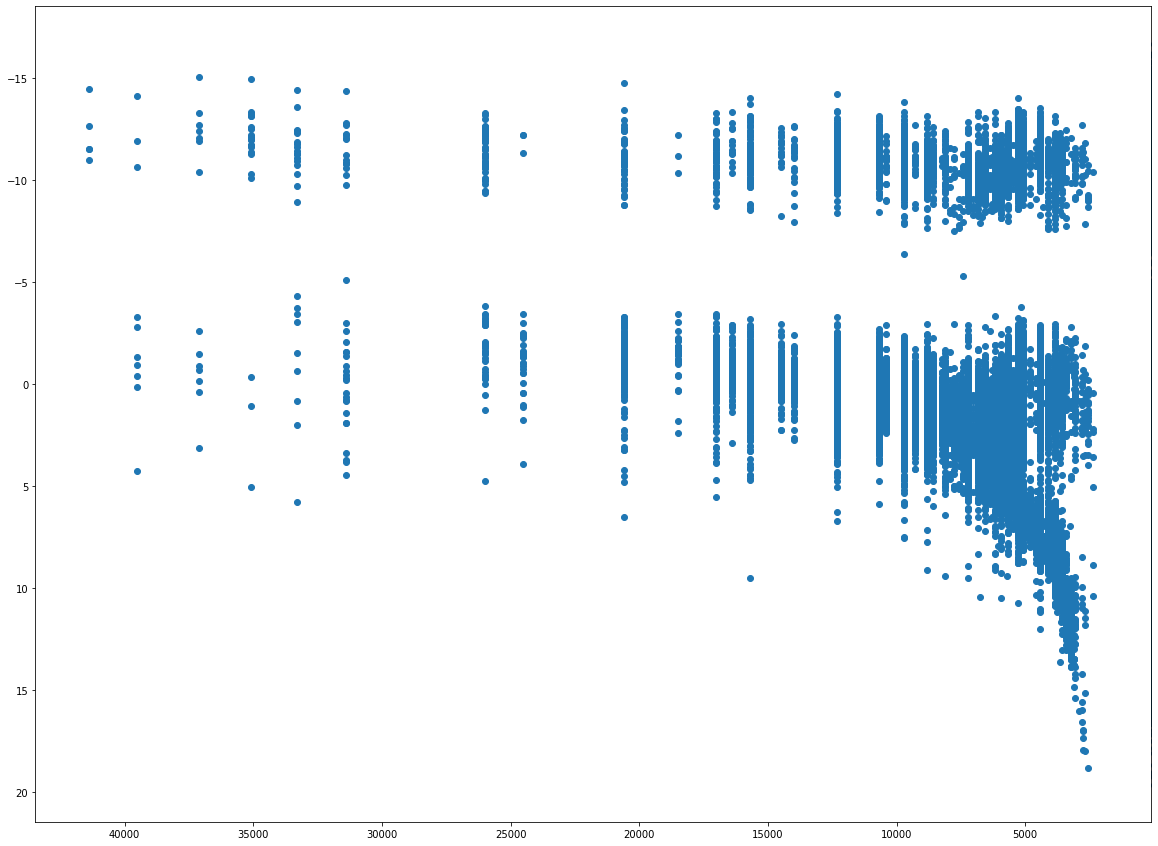

In [26]:
plt.figure(figsize=(20,15))
plt.xlim(100,max(temps)*1.05)

plt.scatter(temps,absmagvals)
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

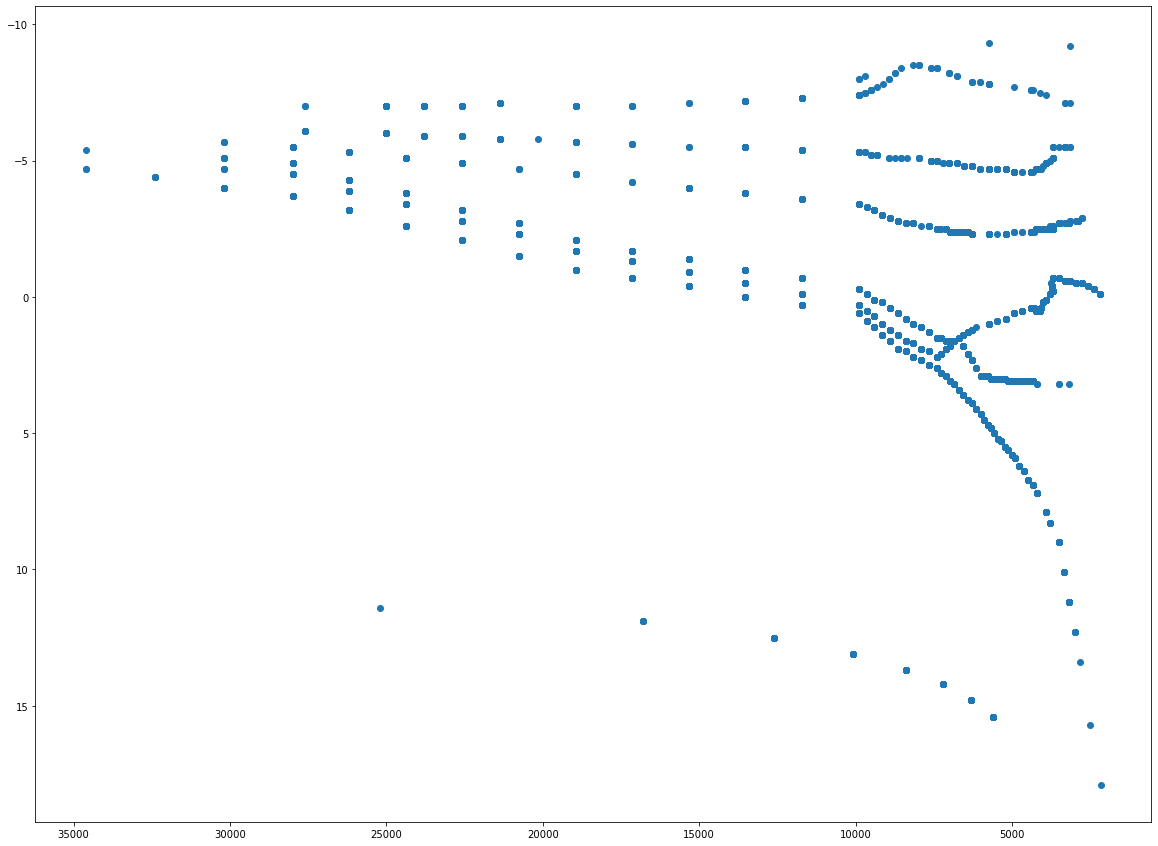

In [51]:
#hertzprung russel diagram
#TODO: add color gradient across, and maybe do some group and text tags to show the different classes (white dwarves, main sequence, etc)
plt.figure(figsize=(20,15))
#plt.xlim(100,max(temps)*1.05)

plt.scatter(data_extended_fullmatch["temperature"],data_extended_fullmatch["abs_mag"])
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

In [49]:
data_extended_fullmatch

,id,hip,hd,hr,gl,bf,proper,ra,dec,dist,...,stellar_type,mass,luminosity,radius,temperature,color_index,abs_mag,bolometric_correction,bolometric_magnitude,rgb
0,0,NaN,NaN,NaN,NaN,NaN,Sol,0.000000,0.000000,0.0000,...,G2V,1.0,1.230000,1.14000,5780,0.69,4.7,-0.18,4.52,255 245 242
1,2,2.0,224690.0,NaN,NaN,NaN,NaN,0.000283,-19.498840,47.9616,...,K3V,0.7,0.335000,0.99000,4480,1.10,6.7,-0.76,5.94,255 222 195
2,4,4.0,224707.0,NaN,NaN,NaN,NaN,0.000569,-51.893546,134.2282,...,F0V,1.6,7.940000,1.77000,7400,0.30,2.6,-0.10,2.50,224 229 255
3,5,5.0,224705.0,NaN,NaN,NaN,NaN,0.000665,-40.591202,257.7320,...,G8III,2.2,124.000000,21.40000,4229,1.19,0.5,-0.98,-0.48,255 231 199
4,10,10.0,224717.0,NaN,NaN,NaN,NaN,0.002424,-50.866976,92.3361,...,F6V,1.3,3.130000,1.41000,6560,0.49,3.6,-0.09,3.51,244 241 255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39726,119533,NaN,NaN,NaN,GJ 1275,NaN,NaN,22.856204,29.662170,20.7039,...,DA9,0.1,0.000067,0.00898,5600,0.74,15.4,-0.22,15.18,255 239 225
39727,119552,NaN,NaN,NaN,Gl 893.1,NaN,NaN,23.240333,-6.548251,24.4499,...,DQ6,0.4,0.000315,0.00864,8400,0.09,13.7,-0.20,13.50,224 230 255
39728,119589,NaN,NaN,NaN,Gl 905.2B,NaN,NaN,23.730688,32.546681,16.6362,...,DA4,0.6,0.001820,0.00922,12600,-0.13,12.5,-0.90,11.60,192 207 255
39729,119596,NaN,NaN,NaN,NN 4365,NaN,NaN,23.831738,29.567389,21.2766,...,DA9,0.1,0.000067,0.00898,5600,0.74,15.4,-0.22,15.18,255 239 225


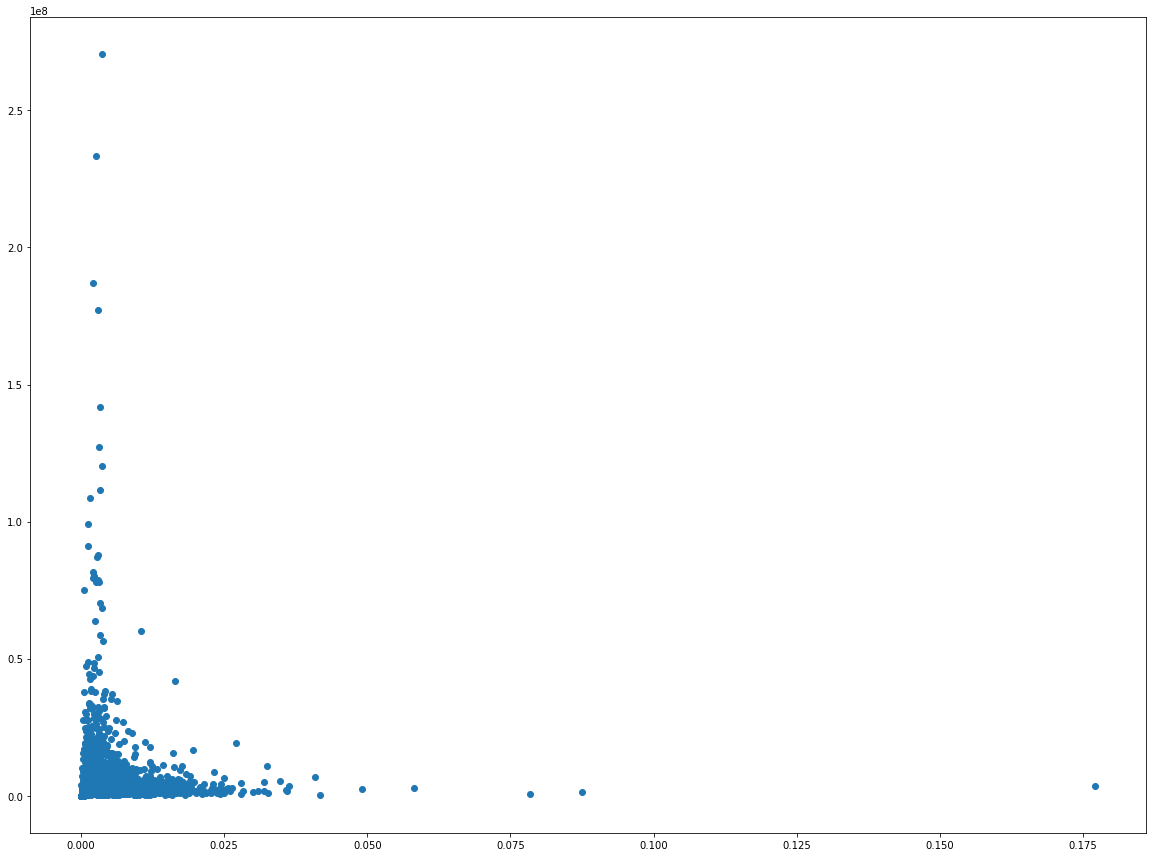

In [53]:
plt.figure(figsize=(20,15))


plt.scatter(data_ef["vtot"],data_ef["lum"])
plt.show()

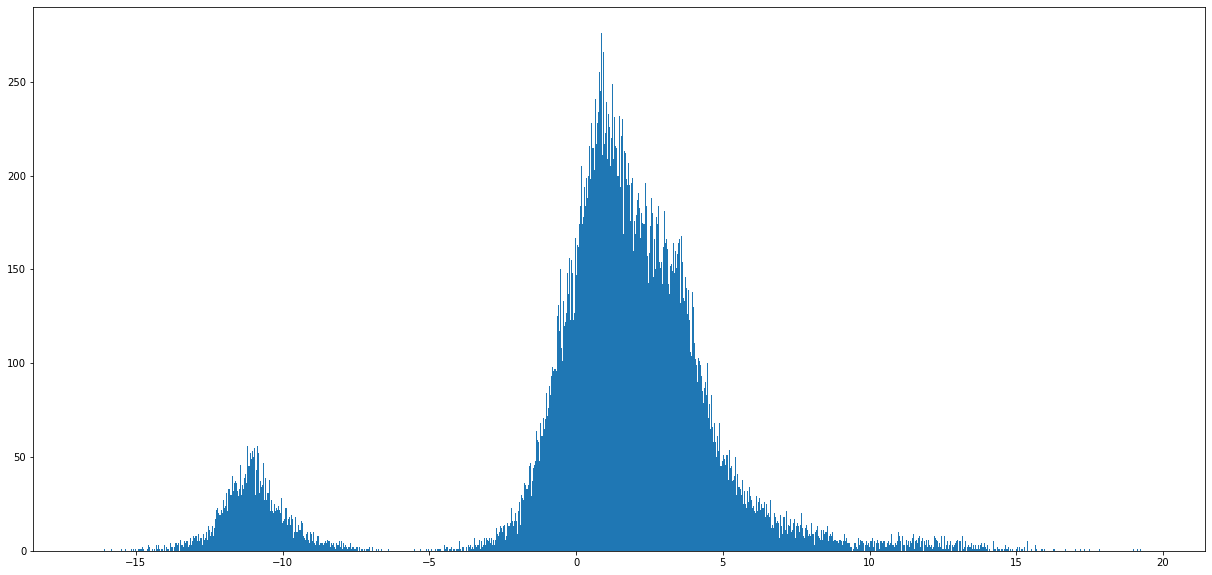

In [28]:
plt.figure(figsize=(21,10))
plt.hist(data["absmag"], bins=np.arange(min(data["absmag"]),max(data["absmag"]),.01))
plt.show()

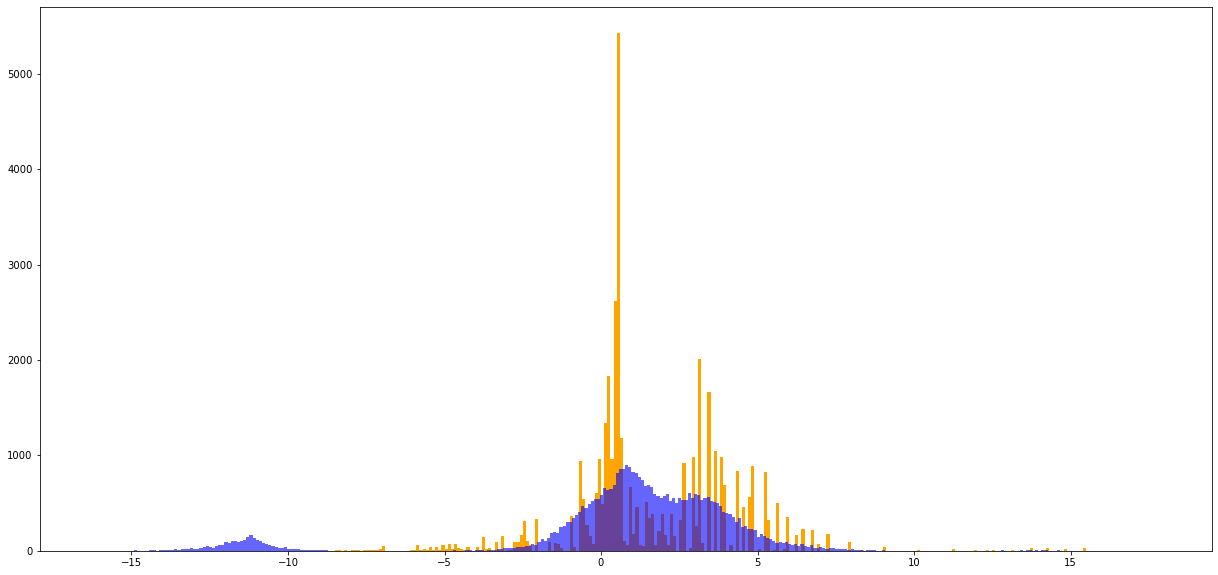

In [73]:
plt.figure(figsize=(21,10))
#plot the absolute magnitude given by the stellar classification
plt.hist(data_ef["abs_mag"], bins=np.arange(min(data_ef["abs_mag"]),max(data_ef["abs_mag"]),.1), color = "orange")
#plot the recorded absolute magnitude given in the data set
plt.hist(data_ef["absmag"], bins=np.arange(min(data_ef["absmag"]),max(data_ef["absmag"]),.1), color = "blue", alpha = 0.6)
plt.show()

In [78]:
#The strange hump below -10 for the observed magnitudes is not at all present in orange plot (which uses the absolute magnitude of the stellar class), lets see why:
data_ef[data_ef["absmag"] <= -10][["spect", "mag","absmag", "stellar_type","abs_mag"]]

,spect,mag,absmag,stellar_type,abs_mag
6,K0III,8.80,-11.20,K0III,0.5
69,G8III,5.87,-14.13,G8III,0.5
70,A2V,7.20,-12.80,A2V,1.1
77,K2III,8.65,-11.35,K2III,0.2
88,B8V,8.69,-11.31,B8V,0.0
...,...,...,...,...,...
39535,K0III,8.93,-11.07,K0III,0.5
39537,K0III,8.01,-11.99,K0III,0.5
39550,O9V,8.72,-11.28,O9V,-4.0
39576,G8III,9.09,-10.91,G8III,0.5


In [81]:
#that first entry is given by the hipparchus catalog as star 13, with an apparent magnitude (mag) of 8.8, which is correctly reflected here, but doest give the apparent magnitude, so it was calculated elsewhere
# lets see if it was calculated properly!
temp = data_ef[data_ef["absmag"] <= -10][["dist","spect", "mag","absmag", "stellar_type","abs_mag"]]
absmag_calc = lambda m, d : m-5*np.log10(d/10)
temp["absmag_calc"] = absmag_calc(temp["mag"], temp["dist"])
temp

,dist,spect,mag,absmag,stellar_type,abs_mag,absmag_calc
6,100000.0,K0III,8.80,-11.20,K0III,0.5,-11.20
69,100000.0,G8III,5.87,-14.13,G8III,0.5,-14.13
70,100000.0,A2V,7.20,-12.80,A2V,1.1,-12.80
77,100000.0,K2III,8.65,-11.35,K2III,0.2,-11.35
88,100000.0,B8V,8.69,-11.31,B8V,0.0,-11.31
...,...,...,...,...,...,...,...
39535,100000.0,K0III,8.93,-11.07,K0III,0.5,-11.07
39537,100000.0,K0III,8.01,-11.99,K0III,0.5,-11.99
39550,100000.0,O9V,8.72,-11.28,O9V,-4.0,-11.28
39576,100000.0,G8III,9.09,-10.91,G8III,0.5,-10.91
